In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('train_u6lujuX_CVtuZ9i.csv')
df = df.drop(columns=['Loan_ID'])
df = pd.get_dummies(df,drop_first=True)

In [2]:
X = df.drop(columns='Loan_Status_Y')
y = df['Loan_Status_Y']

from sklearn.preprocessing import StandardScaler
standardScalerX = StandardScaler()
X = standardScalerX.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify =y,random_state =42)


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_train)

print("Validation Mean Accuracy: ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean())


Validation Mean Accuracy:  0.708843537414966


<Axes: xlabel='Max_Depth', ylabel='Values'>

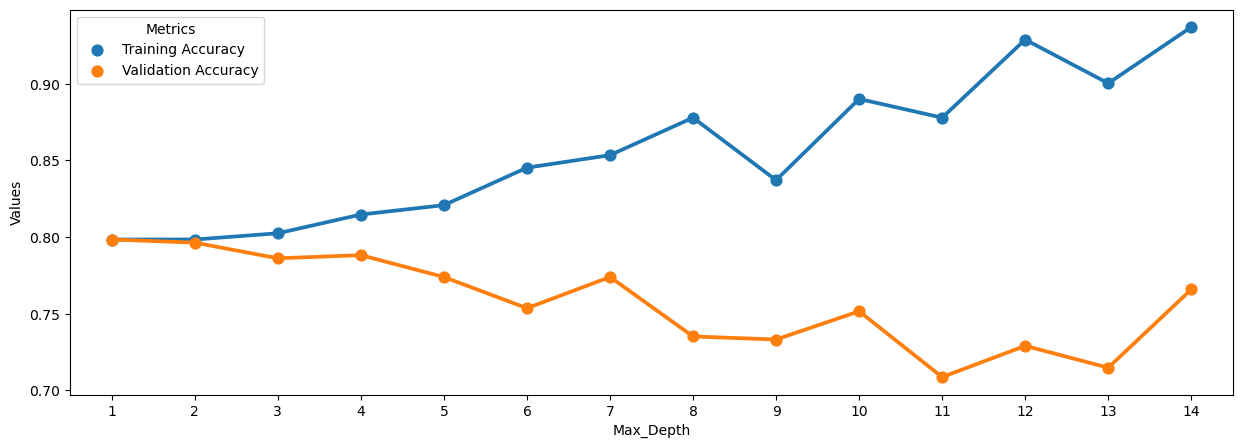

In [3]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
tree_depths = []

for depth in range(1,15):
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    tree_depths.append(depth)
    

Tuning_Max_depth = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Max_Depth": tree_depths }
Tuning_Max_depth_df = pd.DataFrame.from_dict(Tuning_Max_depth)

plot_df = Tuning_Max_depth_df.melt('Max_Depth',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Max_Depth", y="Values",hue="Metrics", data=plot_df,ax=ax)

In [4]:
from sklearn.metrics import confusion_matrix
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.8048780487804879


Predicted,0,1,All
True,,,
0,16,22,38
1,2,83,85
All,18,105,123


In [5]:
df.dropna()
df = df.dropna(how='any',axis=0)
X = df.drop(columns='Loan_Status_Y')
y = df['Loan_Status_Y']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify =y,random_state =42)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529 entries, 1 to 613
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          529 non-null    int64  
 1   CoapplicantIncome        529 non-null    float64
 2   LoanAmount               529 non-null    float64
 3   Loan_Amount_Term         529 non-null    float64
 4   Credit_History           529 non-null    float64
 5   Gender_Male              529 non-null    uint8  
 6   Married_Yes              529 non-null    uint8  
 7   Dependents_1             529 non-null    uint8  
 8   Dependents_2             529 non-null    uint8  
 9   Dependents_3+            529 non-null    uint8  
 10  Education_Not Graduate   529 non-null    uint8  
 11  Self_Employed_Yes        529 non-null    uint8  
 12  Property_Area_Semiurban  529 non-null    uint8  
 13  Property_Area_Urban      529 non-null    uint8  
 14  Loan_Status_Y            5

In [6]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6037735849056604


Text(0, 0.5, 'Cross-Validated Accuracy')

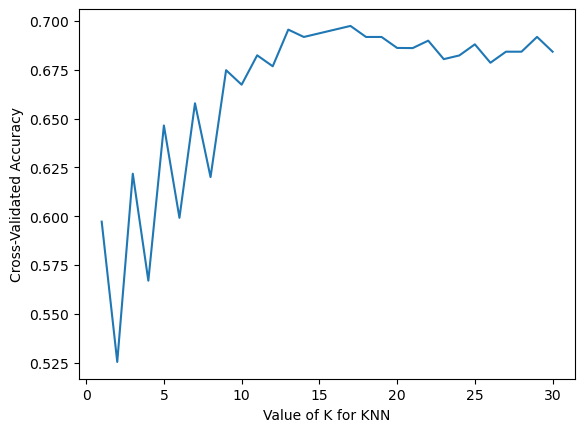

In [7]:
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X, y)

grid_mean_scores = grid.cv_results_['mean_test_score']
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [8]:
print(grid.best_score_)
print(grid.best_params_)

0.6974963715529754
{'n_neighbors': 17}


In [9]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.7075471698113207


Predicted,0,1,All
True,,,
0,5,28,33
1,3,70,73
All,8,98,106


In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import StackingClassifier

rf = RandomForestClassifier()
clf_stack = StackingClassifier(estimators =[('knn',knn), ('tree', tree_clf)], final_estimator = rf)


model_stack = clf_stack.fit(X_train, y_train)
pred_stack = model_stack.predict(X_test)

print("Test Accuracy: ",accuracy_score(y_test,y_pred))
      
conf = confusion_matrix(y_test, y_pred)
conf

Test Accuracy:  0.8113207547169812


array([[15, 18],
       [ 2, 71]], dtype=int64)

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging_classifier = BaggingClassifier( n_estimators=26)
 

bagging_classifier.fit(X_train, y_train)
 
y_pred = bagging_classifier.predict(X_test)
 
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
conf = confusion_matrix(y_test, y_pred)
conf

In [102]:
from sklearn.ensemble import GradientBoostingClassifier

clfgrad = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1).fit(X_train, y_train)
clfgrad.fit(X_test, y_test)
y_pred = clfgrad.predict(X_test)
 
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
conf = confusion_matrix(y_test, y_pred)
conf

Accuracy: 0.9811320754716981


array([[31,  2],
       [ 0, 73]], dtype=int64)

In [13]:
from sklearn.ensemble import AdaBoostClassifier

clfada = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)
clfada.fit(X_test, y_test)
y_pred = clfada.predict(X_test)
 
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
conf = confusion_matrix(y_test, y_pred)
conf

Accuracy: 1.0


array([[33,  0],
       [ 0, 73]], dtype=int64)